In [1]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
import torchvision
from torchvision import transforms as T
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report,  confusion_matrix, ConfusionMatrixDisplay
import sys
sys.path.append('../..')
from augmentation_generator_batch_size import *
from custom_transformers import *

In [2]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

## Load data

In [3]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


# Random Square Cutout - without soft labeling

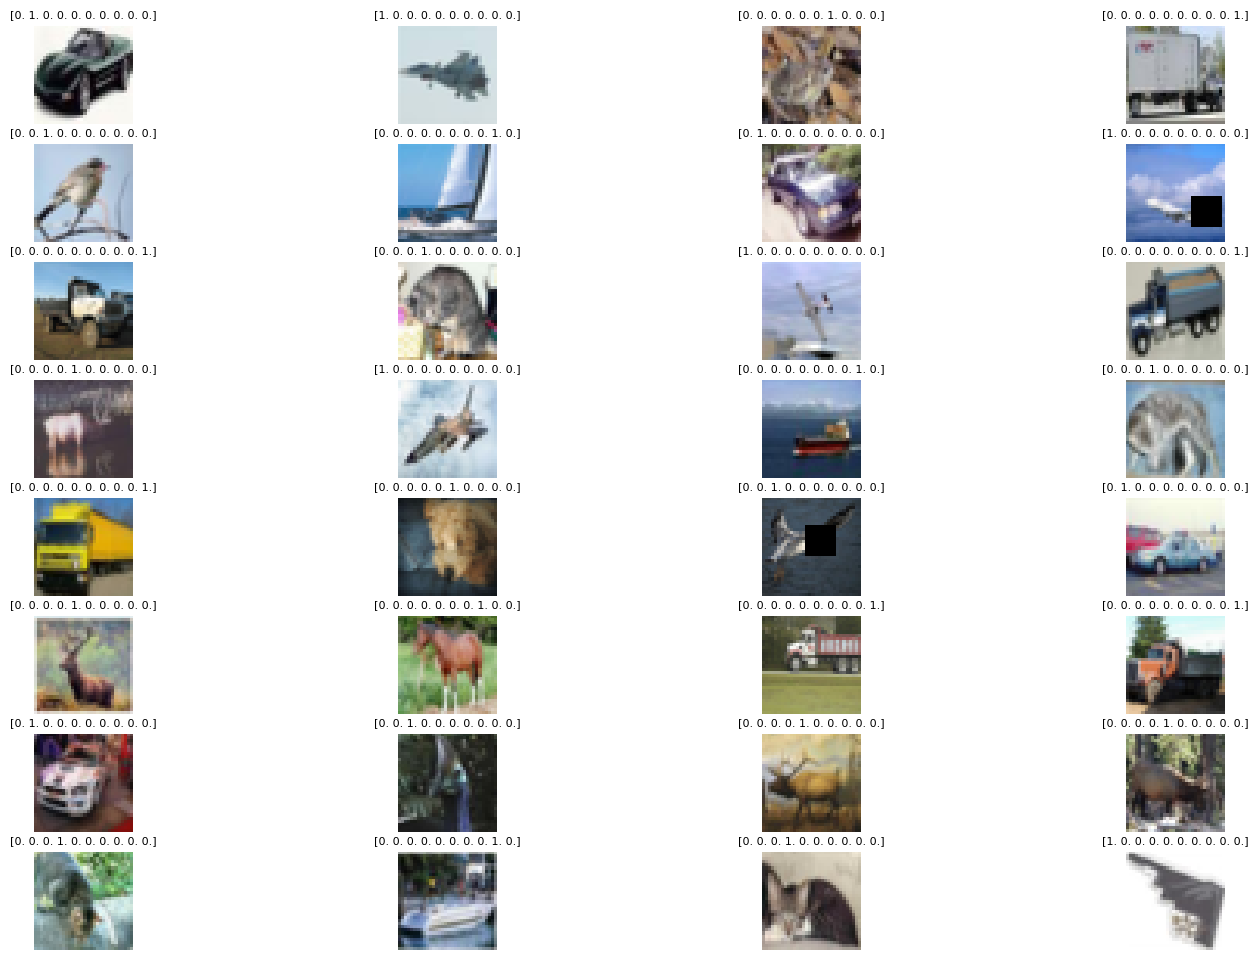

In [ ]:
square_cutout = SquareCutout(size=10, color=False)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor= square_cutout, augment_fraction=0.2, overwrite=False, soft_label=False)

batch_x, batch_y = generator[0]

def denormalize(x):
    x = x.copy()
    x = np.clip(x * 255.0, 0, 255)
    return x.astype(np.uint8)

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

## CNN : Square size = 5
Without soft labels



In [ ]:
square_cutout_5 = SquareCutout(size=5, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=square_cutout_5, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=False)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [ ]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.4538 - loss: 1.6818 - val_accuracy: 0.6408 - val_loss: 1.0616
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.6980 - loss: 0.8661 - val_accuracy: 0.7095 - val_loss: 0.8488
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7638 - loss: 0.6847 - val_accuracy: 0.7356 - val_loss: 0.7594
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8107 - loss: 0.5595 - val_accuracy: 0.7661 - val_loss: 0.7102
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8437 - loss: 0.4579 - val_accuracy: 0.7824 - val_loss: 0.7120
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8747 - loss: 0.3748 - val_accuracy: 0.8119 - val_loss: 0.6072


### Model statistics

In [ ]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


Classification report

In [ ]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1000
           1       0.96      0.86      0.91      1000
           2       0.70      0.78      0.74      1000
           3       0.66      0.64      0.65      1000
           4       0.79      0.79      0.79      1000
           5       0.70      0.77      0.74      1000
           6       0.89      0.84      0.86      1000
           7       0.92      0.78      0.85      1000
           8       0.85      0.92      0.88      1000
           9       0.86      0.91      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



Confusion matrix

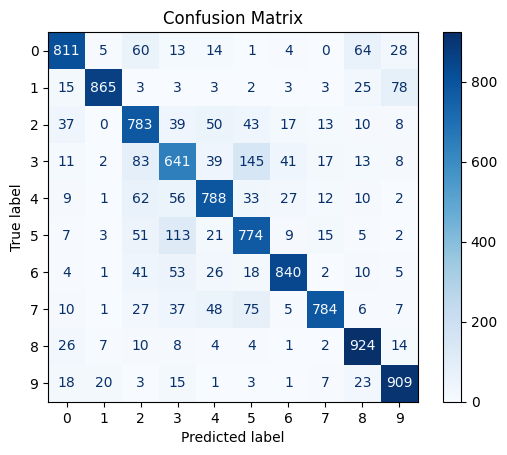

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Accuracy

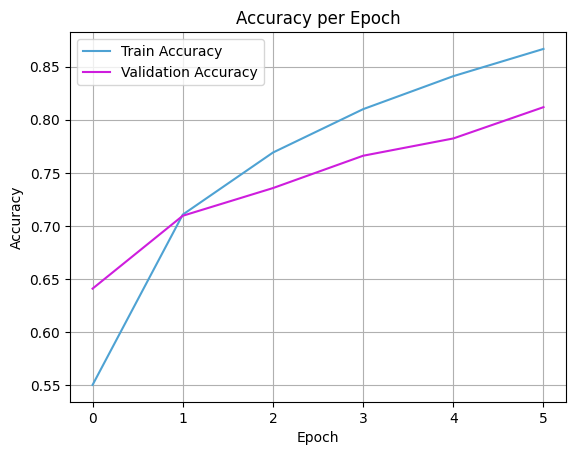

In [ ]:
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

Final Val Acc : 0.81 </br>
Final Train Acc : 0.87

In [ ]:
model.save('square_5.keras')

## CNN : Size = 10
without soft labels

In [ ]:
square_cutout_10 = SquareCutout(size=10, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=square_cutout_10, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=False)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [ ]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.4511 - loss: 1.7361 - val_accuracy: 0.6214 - val_loss: 1.1428
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.6970 - loss: 0.8701 - val_accuracy: 0.7414 - val_loss: 0.7442
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7629 - loss: 0.6865 - val_accuracy: 0.7584 - val_loss: 0.7136
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8032 - loss: 0.5737 - val_accuracy: 0.7862 - val_loss: 0.6310
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8398 - loss: 0.4658 - val_accuracy: 0.7946 - val_loss: 0.6168
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8633 - loss: 0.3954 - val_accuracy: 0.8010 - val_loss: 0.6379


### Model statistics Size = 10

In [ ]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [ ]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1000
           1       0.92      0.89      0.90      1000
           2       0.86      0.59      0.70      1000
           3       0.61      0.67      0.64      1000
           4       0.81      0.76      0.78      1000
           5       0.65      0.82      0.72      1000
           6       0.87      0.81      0.84      1000
           7       0.86      0.85      0.85      1000
           8       0.86      0.92      0.89      1000
           9       0.79      0.93      0.85      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



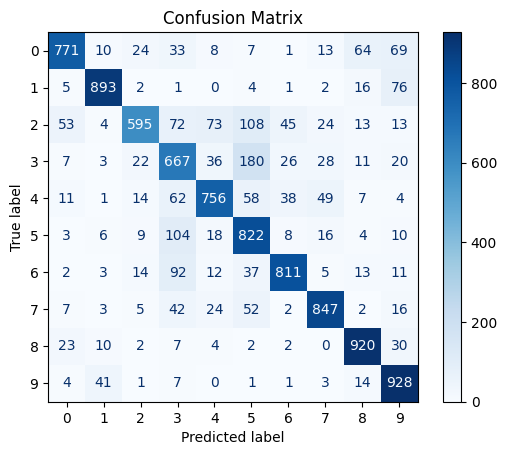

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

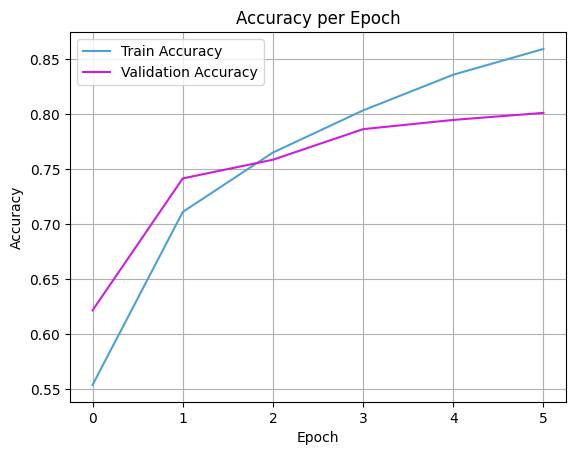

In [ ]:
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

Final Val Acc : 0.80 </br>
Final Train Acc : 0.86

In [ ]:
model.save('square_10.keras')

# Random Square Cutout - with soft labeling

In [ ]:
square_cutout_soft_labels_5 = SquareCutout(size=5, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=square_cutout_soft_labels_5, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [ ]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.4504 - loss: 1.7222 - val_accuracy: 0.6667 - val_loss: 0.9464
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.7005 - loss: 0.8560 - val_accuracy: 0.6992 - val_loss: 0.8425
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.7677 - loss: 0.6717 - val_accuracy: 0.7422 - val_loss: 0.7635
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8093 - loss: 0.5493 - val_accuracy: 0.7272 - val_loss: 0.8621
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8414 - loss: 0.4606 - val_accuracy: 0.7909 - val_loss: 0.6432
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8480 - loss: 0.4844 - val_accuracy: 0.7460 - val_loss: 1.0758


### Model statistics

In [ ]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


              precision    recall  f1-score   support

           0       0.68      0.86      0.76      1000
           1       0.91      0.91      0.91      1000
           2       0.68      0.66      0.67      1000
           3       0.81      0.21      0.34      1000
           4       0.77      0.71      0.74      1000
           5       0.48      0.85      0.62      1000
           6       0.93      0.68      0.78      1000
           7       0.79      0.84      0.81      1000
           8       0.83      0.90      0.86      1000
           9       0.89      0.84      0.86      1000

    accuracy                           0.75     10000
   macro avg       0.78      0.75      0.74     10000
weighted avg       0.78      0.75      0.74     10000



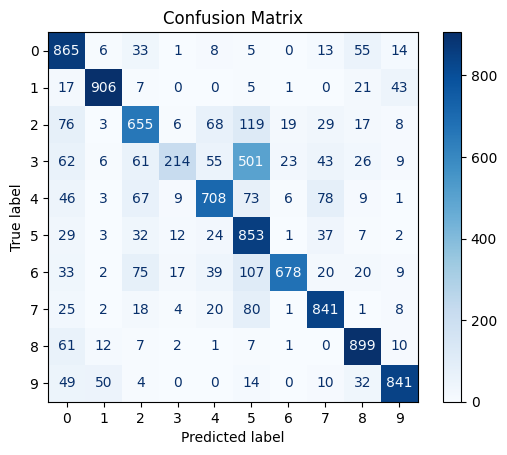

In [ ]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Final Training Accuracy: 0.8117
Final Validation Accuracy: 0.7460


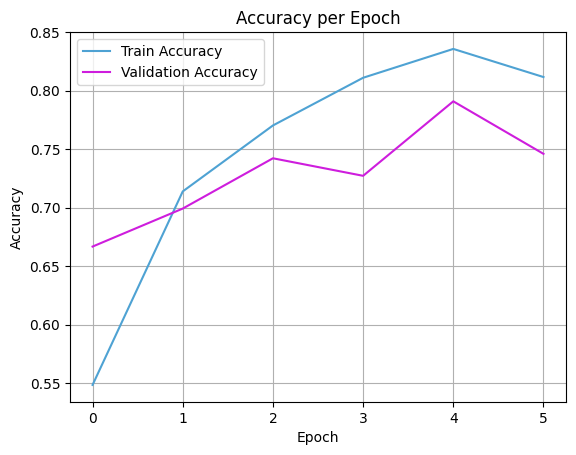

In [ ]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

In [ ]:
model.save('square_005_soft_labels.keras')

# Random Square Cutout
with soft labeling 0.9999

In [4]:
square_cutout_soft_labels_5 = SquareCutout(size=5, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=square_cutout_soft_labels_5, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [5]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.4484 - loss: 1.7309 - val_accuracy: 0.6391 - val_loss: 1.0328
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.6975 - loss: 0.8680 - val_accuracy: 0.7264 - val_loss: 0.7956
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7666 - loss: 0.6760 - val_accuracy: 0.7515 - val_loss: 0.7487
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.8091 - loss: 0.5499 - val_accuracy: 0.7679 - val_loss: 0.6763
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8428 - loss: 0.4584 - val_accuracy: 0.8161 - val_loss: 0.5834
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8745 - loss: 0.3692 - val_accuracy: 0.8048 - val_loss: 0.6210


### Model statistics

In [7]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose = 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1000
           1       0.88      0.93      0.90      1000
           2       0.70      0.74      0.72      1000
           3       0.73      0.55      0.63      1000
           4       0.80      0.76      0.78      1000
           5       0.77      0.68      0.72      1000
           6       0.74      0.93      0.83      1000
           7       0.91      0.82      0.86      1000
           8       0.83      0.92      0.87      1000
           9       0.89      0.89      0.89      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



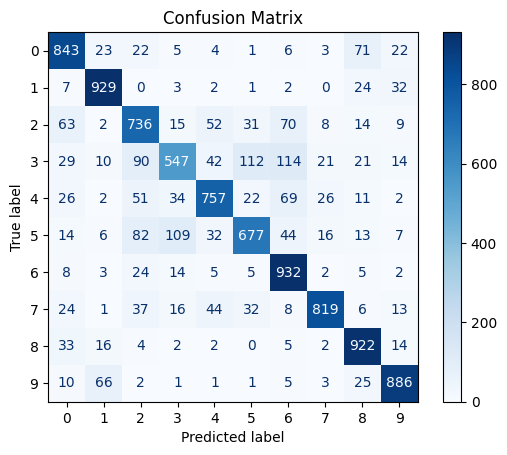

In [8]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Final Training Accuracy: 0.8686
Final Validation Accuracy: 0.8048


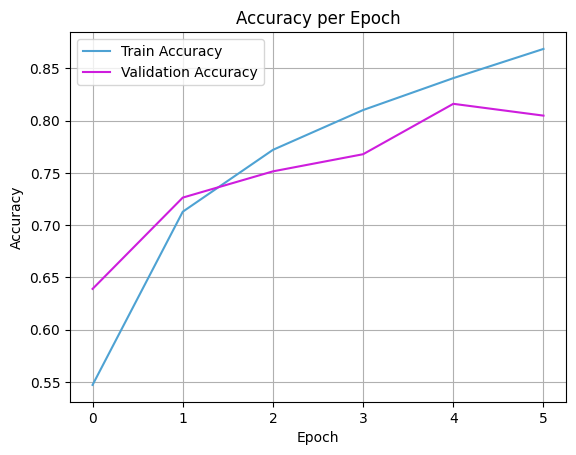

In [9]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()